In [ ]:
# import Libraries
import numpy as np
import matplotlib.pyplot as plt
import rasterio
from rasterio.control import GroundControlPoint
from rasterio.crs import CRS
from rasterio.features import rasterize
import xml.etree.ElementTree as ET
import geopandas as gpd
from scipy.interpolate import interp1d
from scipy.interpolate import griddata
from scipy.ndimage import map_coordinates
import pandas as pd
from pathlib import Path
import rasterio
import numpy as np
from lxml import etree

Load the data (HH, HV images from .img file & product.xml)

In [33]:
def load_all_rcm_products(data_dir):
    """
    # Load all RCM products from a data directory.
    # For each product folder, this function:
    # - Finds the SAR .img file and product.xml metadata
    # - Reads HH and HV polarization bands from the image
    # - Parses the XML metadata
    # - Stores the image data and metadata in a list of dictionaries
    """
    data_dir = Path(data_dir)

    if not data_dir.is_dir():
        raise ValueError("data_dir must be a directory")

    dataset = []

    for product_dir in sorted(data_dir.iterdir()):
        if not product_dir.is_dir():
            continue

        try:
            # find files
            img_files = list(product_dir.rglob("*.img"))
            xml_files = list(product_dir.rglob("product.xml"))

            if len(img_files) != 1:
                raise ValueError("expected exactly one .img file")
            if not xml_files:
                raise FileNotFoundError("product.xml not found")

            img_path = img_files[0]

            # read HH / HV from bands
            with rasterio.open(img_path) as src:
                if src.count != 2:
                    raise ValueError(f"expected 2 bands, found {src.count}")

                hh = src.read(1)
                hv = src.read(2)

            # read XML
            with open(xml_files[0], "rb") as f:
                xml_root = etree.parse(f).getroot()

            dataset.append({
                "name": product_dir.name,
                "hh": hh,
                "hv": hv,
                "xml": xml_root
            })

        except Exception as e:
            print(f"Skipping {product_dir.name}: {e}")

    return dataset

In [28]:
dataset = load_all_rcm_products("./data2")
for i, item in enumerate(dataset):
    print(f"{i}: {item['name']}")
    print("   HH shape:", item["hh"].shape)
    print("   HV shape:", item["hv"].shape)

Loaded: RCM1_OK1132487_PK1188497_2_SC50MB_20200803_121918_HH_HV_GRD.zip
Loaded: RCM1_OK1303083_PK1399620_1_SC50MC_20201202_232538_HH_HV_GRD.zip
Loaded: RCM1_OK1303083_PK1399620_2_SC50MC_20201202_232538_HH_HV_GRD.zip
Loaded: RCM1_OK1352580_PK1476461_1_SC50MC_20210129_103438_HH_HV_GRD.zip
Loaded: RCM1_OK1352580_PK1494937_1_SC50MB_20210218_113859_HH_HV_GRD.zip
Loaded: RCM1_OK2322217_PK2524735_1_SCLNB_20230422_224659_HH_HV_GRD.zip
Loaded: RCM1_OK2333297_PK2553234_4_SCLNB_20230514_130201_HH_HV_GRD.zip
Loaded: RCM1_OK2548085_PK2560440_1_SCLNB_20230517_225618_HH_HV_GRD.zip
Loaded: RCM1_OK2589381_PK2874076_1_SCLNB_20231214_235203_HH_HV_GRD.zip
Loaded: RCM1_OK2589382_PK2885940_1_SCLNB_20231225_124433_HH_HV_GRD.zip
0: RCM1_OK1132487_PK1188497_2_SC50MB_20200803_121918_HH_HV_GRD.zip
   HH shape: (20475, 18239)
   HV shape: (20475, 18239)
1: RCM1_OK1303083_PK1399620_1_SC50MC_20201202_232538_HH_HV_GRD.zip
   HH shape: (25903, 24561)
   HV shape: (25903, 24561)
2: RCM1_OK1303083_PK1399620_2_SC50MC_20

Using sample: RCM1_OK1132487_PK1188497_2_SC50MB_20200803_121918_HH_HV_GRD.zip


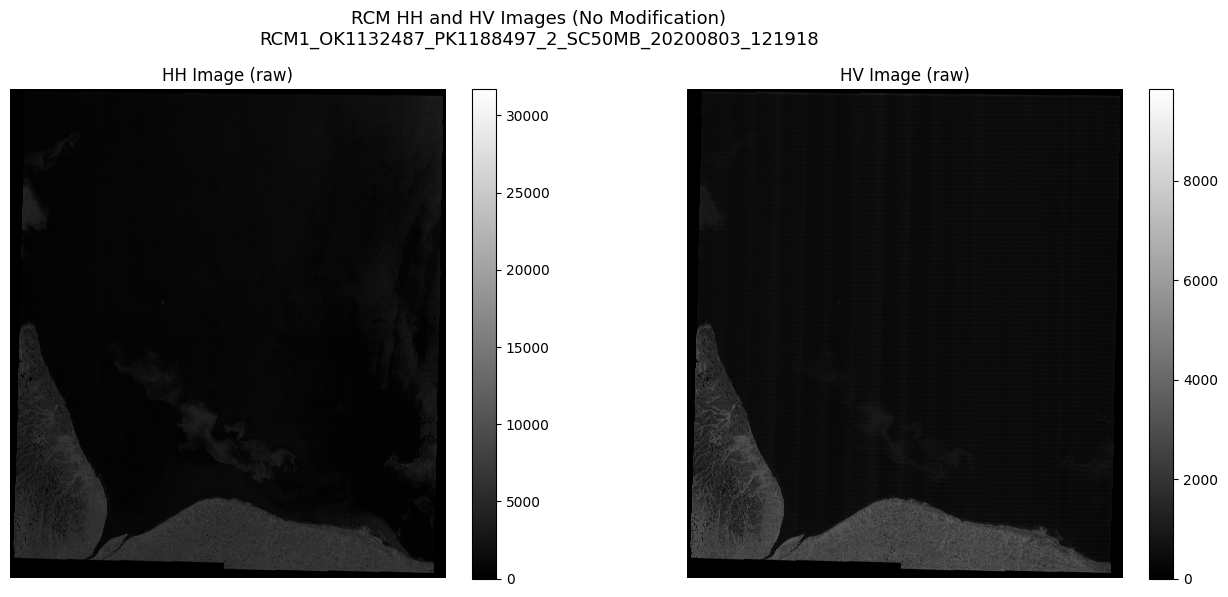

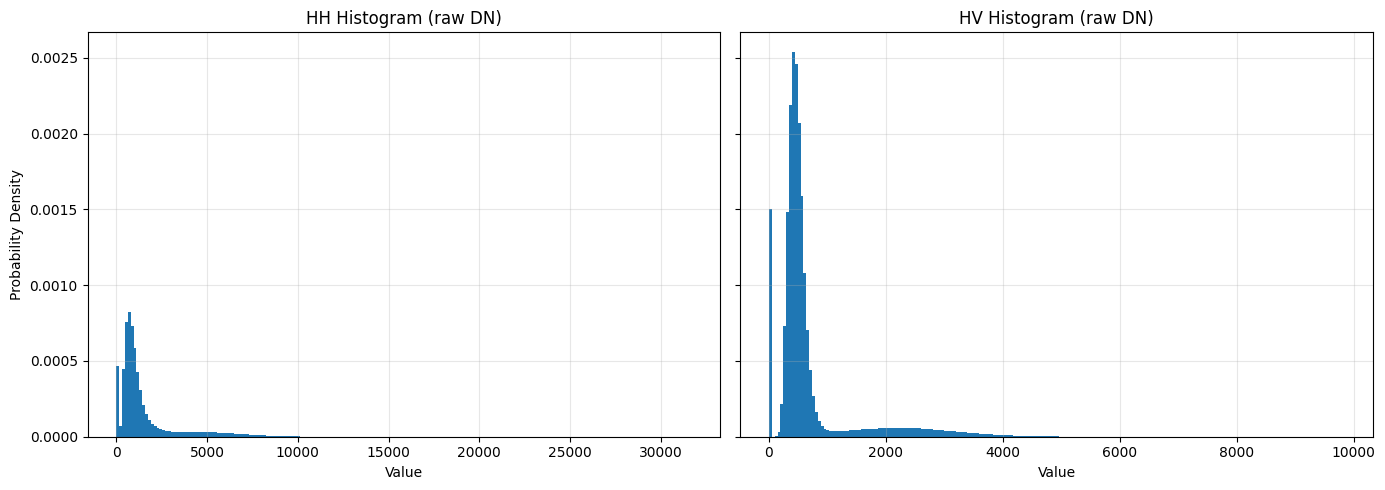

In [ ]:
# plot HH, HV images & Histograms for 1 sample scene => RCM1_OK1132487_PK1188497_2_SC50MB_20200803_121918_HH_HV_GRD.zip
dataset = load_all_rcm_products("./data2")
print("Using sample:", dataset[0]["name"])

hh = dataset[0]["hh"]
hv = dataset[0]["hv"]

# Plot HH & HV images =====================
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

im0 = axs[0].imshow(hh, cmap="gray")
axs[0].set_title("HH Image (raw)")
axs[0].axis("off")
fig.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

im1 = axs[1].imshow(hv, cmap="gray")
axs[1].set_title("HV Image (raw)")
axs[1].axis("off")
fig.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

plt.suptitle(
    "RCM HH and HV Images (No Modification)\n"
    "RCM1_OK1132487_PK1188497_2_SC50MB_20200803_121918",
    fontsize=13
)
plt.tight_layout()
plt.show()

# Plot HH & HV histograms
fig, axs = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

axs[0].hist(hh.ravel(), bins=200, density=True)
axs[0].set_title("HH Histogram (raw DN)")
axs[0].set_xlabel("Value")
axs[0].set_ylabel("Probability Density")
axs[0].grid(alpha=0.3)

axs[1].hist(hv.ravel(), bins=200, density=True)
axs[1].set_title("HV Histogram (raw DN)")
axs[1].set_xlabel("Value")
axs[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()


Extract Product ID, Geocoded info (lat/long), Pixel spacing

In [35]:
def extract_rcm_product_metadata(data_dir):
    """
    Loop over all RCM product folders in data_dir and extract:
    - Product ID
    - All geocoded latitude/longitude points
    - Pixel spacing (pixel & line)
    """

    data_dir = Path(data_dir)
    all_metadata = []

    for product_dir in data_dir.iterdir():
        if not product_dir.is_dir():
            continue

        xml_files = list(product_dir.rglob("product.xml"))
        if not xml_files:
            continue

        xml_root = etree.parse(str(xml_files[0])).getroot()
        ns = {"rcm": xml_root.tag.split("}")[0].strip("{")}

        metadata = {}

        # product ID
        product_id_elem = xml_root.find(".//rcm:productId", ns)
        metadata["product_id"] = (
            product_id_elem.text.strip() if product_id_elem is not None else None
        )

        # pixel spacing
        range_spacing_elem = xml_root.find(".//rcm:sampledPixelSpacing", ns)
        azimuth_spacing_elem = xml_root.find(".//rcm:sampledLineSpacing", ns)

        metadata["pixel_spacing"] = {
            "range_m": float(range_spacing_elem.text)
            if range_spacing_elem is not None else None,
            "azimuth_m": float(azimuth_spacing_elem.text)
            if azimuth_spacing_elem is not None else None,
        }

        # all geocoded lat/lon points
        geocoded_points = []
        geodetic_coords = xml_root.findall(".//rcm:geodeticCoordinate", ns)

        for coord in geodetic_coords:
            lat = coord.find("rcm:latitude", ns)
            lon = coord.find("rcm:longitude", ns)

            if lat is not None and lon is not None:
                geocoded_points.append({
                    "latitude": float(lat.text),
                    "longitude": float(lon.text)
                })

        metadata["geocoded_points"] = geocoded_points
        metadata["folder_name"] = product_dir.name

        all_metadata.append(metadata)

    return all_metadata


In [36]:
all_metadata = extract_rcm_product_metadata("./data2")

for meta in all_metadata:
    print("=" * 60)
    print("Folder name:", meta["folder_name"])
    print("Product ID:", meta["product_id"])
    print("Pixel spacing:", meta["pixel_spacing"])

    # print just the first 5 geocoded lat/lon points here
    print("First 5 geocoded lat/lon points:")
    for p in meta["geocoded_points"][:5]:
        print("  ", p)


Folder name: RCM1_OK1132487_PK1188497_2_SC50MB_20200803_121918_HH_HV_GRD.zip
Product ID: 1188497_2
Pixel spacing: {'range_m': 20.0, 'azimuth_m': 20.0}
First 5 geocoded lat/lon points:
   {'latitude': 60.57982843770729, 'longitude': -92.93818333403263}
   {'latitude': 60.54318604055006, 'longitude': -92.39204788346551}
   {'latitude': 60.50431813419547, 'longitude': -91.84718225856555}
   {'latitude': 60.4632335359961, 'longitude': -91.3036561888817}
   {'latitude': 60.41994152041963, 'longitude': -90.7615382156817}
Folder name: RCM1_OK1303083_PK1399620_1_SC50MC_20201202_232538_HH_HV_GRD.zip
Product ID: 1399620_1
Pixel spacing: {'range_m': 20.0, 'azimuth_m': 20.0}
First 5 geocoded lat/lon points:
   {'latitude': 54.88329768313773, 'longitude': -86.95036284860767}
   {'latitude': 54.93414039464033, 'longitude': -86.48904533589437}
   {'latitude': 54.98323016541521, 'longitude': -86.02658344275537}
   {'latitude': 55.03055956216005, 'longitude': -85.56301268053227}
   {'latitude': 55.0761

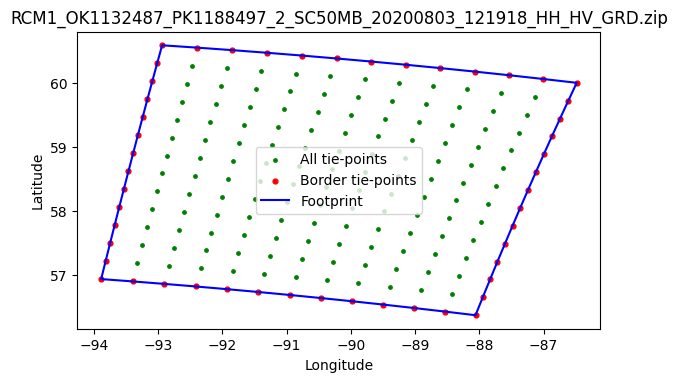

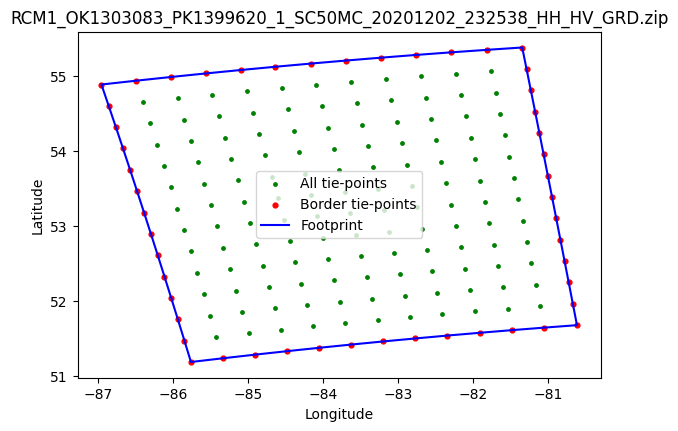

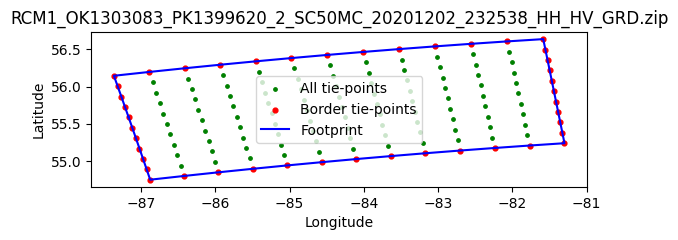

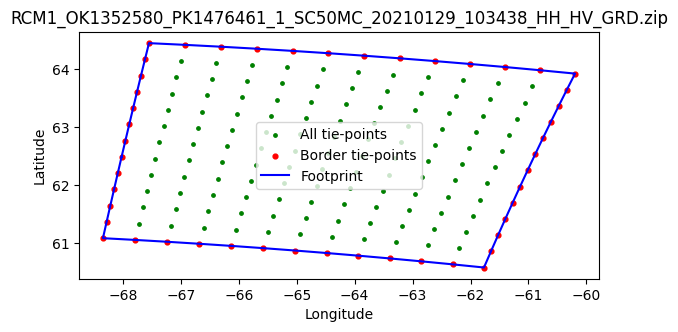

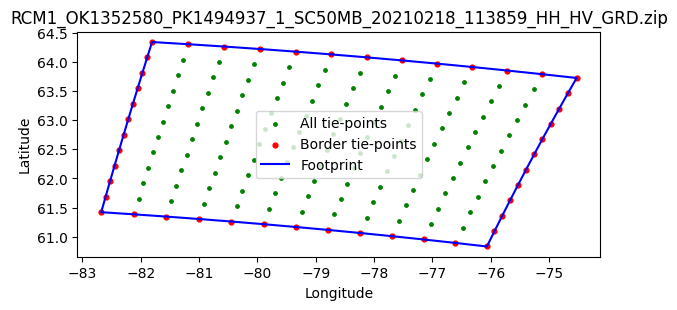

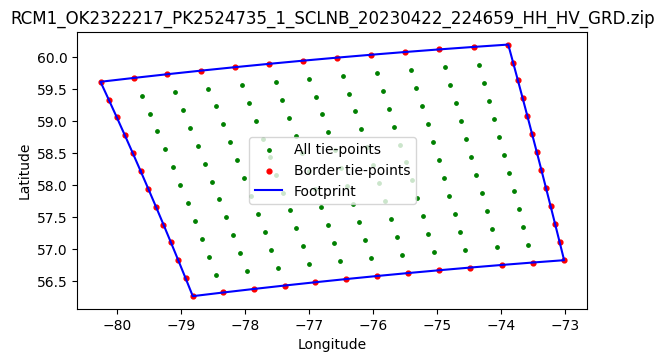

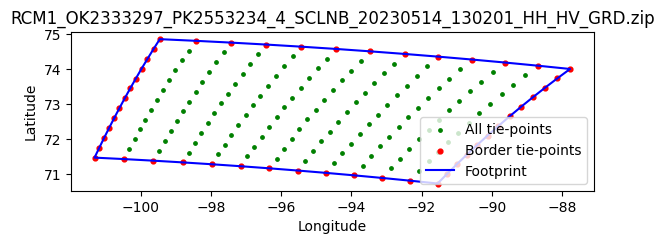

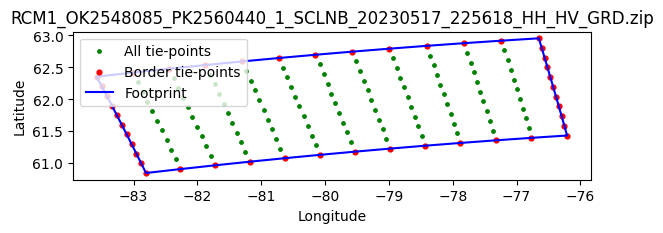

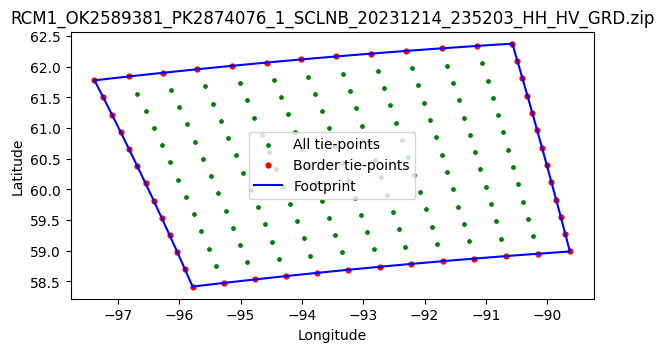

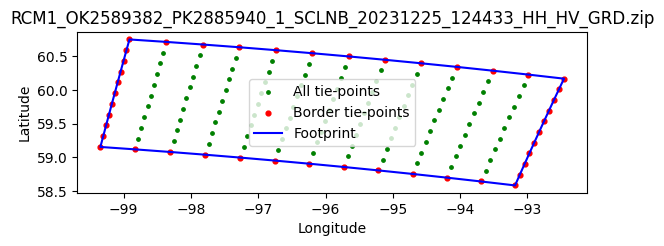

In [ ]:
# plot all grid points

import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# ===================== Plot tie-points & footprints =====================
for item in dataset:
    xml_root = item["xml"]
    name = item["name"]

    # namespace
    ns = {"ns": xml_root.tag.split('}')[0].strip('{')}

    # find tie-points
    tie_pts = xml_root.findall(".//ns:geolocationGrid/ns:imageTiePoint", namespaces=ns)

    if len(tie_pts) == 0:
        print(f"Skipping {name}: no tie-points found")
        continue

    lines, pixels, lats, lons = [], [], [], []

    for tp in tie_pts:
        img = tp.find("ns:imageCoordinate", namespaces=ns)
        geo = tp.find("ns:geodeticCoordinate", namespaces=ns)

        lines.append(float(img.find("ns:line", namespaces=ns).text))
        pixels.append(float(img.find("ns:pixel", namespaces=ns).text))
        lats.append(float(geo.find("ns:latitude", namespaces=ns).text))
        lons.append(float(geo.find("ns:longitude", namespaces=ns).text))

    # identify border tie-points
    min_line, max_line = min(lines), max(lines)
    min_pix,  max_pix  = min(pixels), max(pixels)

    border_mask = [
        (ln in (min_line, max_line) or px in (min_pix, max_pix))
        for ln, px in zip(lines, pixels)
    ]

    border_pts = [
        (lon, lat) for lon, lat, is_b in zip(lons, lats, border_mask) if is_b
    ]

    if len(border_pts) < 3:
        print(f"Skipping {name}: insufficient border points")
        continue

    # sort border points counter-clockwise
    cx = np.mean([p[0] for p in border_pts])
    cy = np.mean([p[1] for p in border_pts])
    border_pts_sorted = sorted(
        border_pts,
        key=lambda p: np.arctan2(p[1] - cy, p[0] - cx)
    )

    footprint = Polygon(border_pts_sorted)

    # ===================== Plot =====================
    plt.figure(figsize=(6, 6))
    plt.scatter(lons, lats, s=6, c="green", label="All tie-points")
    plt.scatter(*zip(*border_pts), s=12, c="red", label="Border tie-points")

    x, y = footprint.exterior.xy
    plt.plot(x, y, color="blue", linewidth=1.5, label="Footprint")

    plt.gca().set_aspect("equal", "box")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(name)
    plt.legend()
    plt.tight_layout()
    plt.show()


Scale HH and HV channels to 200m pixel spacing

In [ ]:
import numpy as np
from scipy.ndimage import zoom

def rescale_to_200m(hh, hv, pixel_spacing_m, target_spacing=200):
    """
    Rescale HH and HV channels to a target pixel spacing (default: 200 m).

    Parameters:
    - hh, hv: numpy arrays (H x W)
    - pixel_spacing_m: original pixel spacing in meters
    - target_spacing: desired pixel spacing in meters

    Returns:
    - hh_rescaled, hv_rescaled
    """

    scale_factor = pixel_spacing_m / target_spacing

    if scale_factor == 1.0:
        return hh, hv

    hh_rescaled = zoom(hh, zoom=scale_factor, order=1)  # bilinear
    hv_rescaled = zoom(hv, zoom=scale_factor, order=1)

    return hh_rescaled, hv_rescaled
